In [2]:
import os
import sys
# Add Scripts folder to sys.path
script_path = os.path.abspath(os.path.join(os.getcwd(), "..", "Scripts"))
if script_path not in sys.path:
    sys.path.append(script_path)
import torch
import torch.nn as nn
import torch.nn.functional as F
import os
import glob
from PIL import Image
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from MultiAttention_Unet.MultiImage_Unet import MultiImageUNet
from Data_preprocess import process_images_into_sequences
from Data_preprocess import create_dataloaders
from MultiAttention_Unet.Unet_Model import UnetModel
from ML_Func import calculate_metrics, display_image
os.chdir("..")
# Process images into sequences
reference_images, sequence_images = process_images_into_sequences(image_dir='Dataset_images')

# Create dataloaders
train_loader, val_loader, test_loader = create_dataloaders(
    reference_images, 
    sequence_images,
    batch_size=2, 
    train_ratio=0.8, 
    val_ratio=0.1, 
    test_ratio=0.1, 
    shuffle=True, 
    num_workers=0
)

Loaded slice-001.png | raw 16-bit range [0,61776] → mapped to uint8
Loaded slice-002.png | raw 16-bit range [0,61781] → mapped to uint8
Loaded slice-003.png | raw 16-bit range [0,61132] → mapped to uint8
Loaded slice-004.png | raw 16-bit range [0,61515] → mapped to uint8
Loaded slice-005.png | raw 16-bit range [0,63076] → mapped to uint8
Loaded slice-006.png | raw 16-bit range [0,62637] → mapped to uint8
Loaded slice-007.png | raw 16-bit range [0,62916] → mapped to uint8
Loaded slice-008.png | raw 16-bit range [0,61260] → mapped to uint8
Loaded slice-009.png | raw 16-bit range [0,61964] → mapped to uint8
Loaded slice-010.png | raw 16-bit range [0,61040] → mapped to uint8
Loaded slice-011.png | raw 16-bit range [0,61544] → mapped to uint8
Loaded slice-012.png | raw 16-bit range [0,61110] → mapped to uint8
Loaded slice-013.png | raw 16-bit range [0,62125] → mapped to uint8
Loaded slice-014.png | raw 16-bit range [0,62330] → mapped to uint8
Loaded slice-015.png | raw 16-bit range [0,63016

Using device: cuda


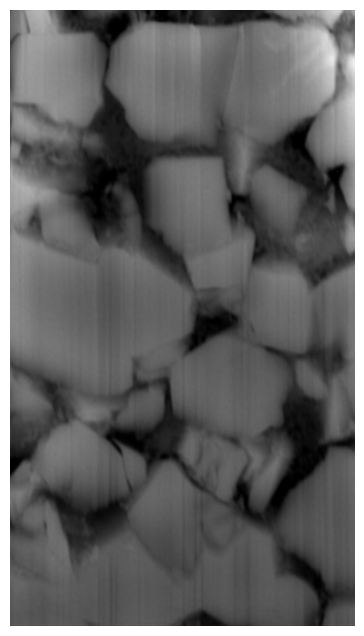

SSIM: 0.5272936669298027, PSNR: 3.4329261562956925


In [4]:
refer_images = reference_images[250]
seq_images = sequence_images[250]

# 调整大小
refer_images = F.interpolate(refer_images, size=(800, 800), mode='bilinear', align_corners=False)
seq_images = F.interpolate(seq_images, size=(800, 800), mode='bilinear', align_corners=False)

refer_images = refer_images.unsqueeze(0)
seq_images = seq_images.unsqueeze(0)

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

refer_images = refer_images.to(device)
seq_images = seq_images.to(device)
# 载入模型
model = UnetModel(in_channels=1).to(device)
model.load_state_dict(torch.load('Model/unet_model.pth', map_location=device))
model.eval()

outputs = model(seq_images, refer_images)

outputs = outputs.squeeze(0)
outputs = outputs.squeeze(1)
from PIL import Image
import numpy as np
x = outputs[0,:,:].detach().cpu().numpy()  # 第一组图像的第一帧，移除通道维度
img8 = Image.fromarray(x.astype(np.uint8), mode='L')
img8.show()
display_image(img8)
img8.save('Sample_Dataset/slice-004-interp_dl.png') 
# Test the model
ssim_value, psnr_value = calculate_metrics(
    'Sample_Dataset/slice-004-interp_dl.png',
    'Sample_Dataset/slice-004.png'
)
print(f"SSIM: {ssim_value}, PSNR: {psnr_value}")